In [16]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [19]:
#Loading the training and validation datasets
train_data = pd.read_csv("twitter_training.csv")
validation_data = pd.read_csv("twitter_validation.csv")

In [20]:
train_head = train_data.head()
validation_head = validation_data.head()

train_head, validation_head

(   2401  Borderlands  Positive  \
 0  2401  Borderlands  Positive   
 1  2401  Borderlands  Positive   
 2  2401  Borderlands  Positive   
 3  2401  Borderlands  Positive   
 4  2401  Borderlands  Positive   
 
   im getting on borderlands and i will murder you all ,  
 0  I am coming to the borders and I will kill you...     
 1  im getting on borderlands and i will kill you ...     
 2  im coming on borderlands and i will murder you...     
 3  im getting on borderlands 2 and i will murder ...     
 4  im getting into borderlands and i can murder y...     ,
    3364   Facebook Irrelevant  \
 0   352     Amazon    Neutral   
 1  8312  Microsoft   Negative   
 2  4371      CS-GO   Negative   
 3  4433     Google    Neutral   
 4  6273       FIFA   Negative   
 
   I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy,

In [21]:
train_data.columns=['TweetID','entity','sentiment','Tweet content']
train_data.head()

,TweetID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [22]:
validation_head.columns=['TweetID','entity','sentiment','Tweet content']
validation_head.head()

,TweetID,entity,sentiment,Tweet content
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [23]:
#Checking for missing values
missing_train = train_data.isnull().sum()
missing_validation = validation_data.isnull().sum()

In [24]:
#Checking for duplicate rows
duplicates_train = train_data.duplicated().sum()
duplicates_validation = validation_data.duplicated().sum()

missing_train, missing_validation, duplicates_train, duplicates_validation

(TweetID            0
 entity             0
 sentiment          0
 Tweet content    686
 dtype: int64,
 3364                                                                                                                                                                                                                                                  0
 Facebook                                                                                                                                                                                                                                              0
 Irrelevant                                                                                                                                                                                                                                            0
 I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayle

In [26]:
#Checking the distribution of sentiment labels
train_sentiment_distribution = train_data.iloc[:, 2].value_counts()
validation_sentiment_distribution = validation_data.iloc[:, 2].value_counts()

In [28]:
#Checking the number of unique entities in the training set
unique_entities_train = train_data.iloc[:, 1].nunique()

train_sentiment_distribution, validation_sentiment_distribution, unique_entities_train

(Negative      22542
 Positive      20831
 Neutral       18318
 Irrelevant    12990
 Name: sentiment, dtype: int64,
 Neutral       285
 Positive      277
 Negative      266
 Irrelevant    171
 Name: Irrelevant, dtype: int64,
 32)

In [29]:
#Removing duplicate rows from the training set
train_data_cleaned = train_data.drop_duplicates()

In [30]:
#Dropping rows with missing tweet/message values
train_data_cleaned = train_data_cleaned.dropna(subset=[train_data.columns[3]])

In [31]:
#Verifying the cleaning
remaining_duplicates_train = train_data_cleaned.duplicated().sum()
remaining_missing_train = train_data_cleaned.isnull().sum()

remaining_duplicates_train, remaining_missing_train

(0,
 TweetID          0
 entity           0
 sentiment        0
 Tweet content    0
 dtype: int64)

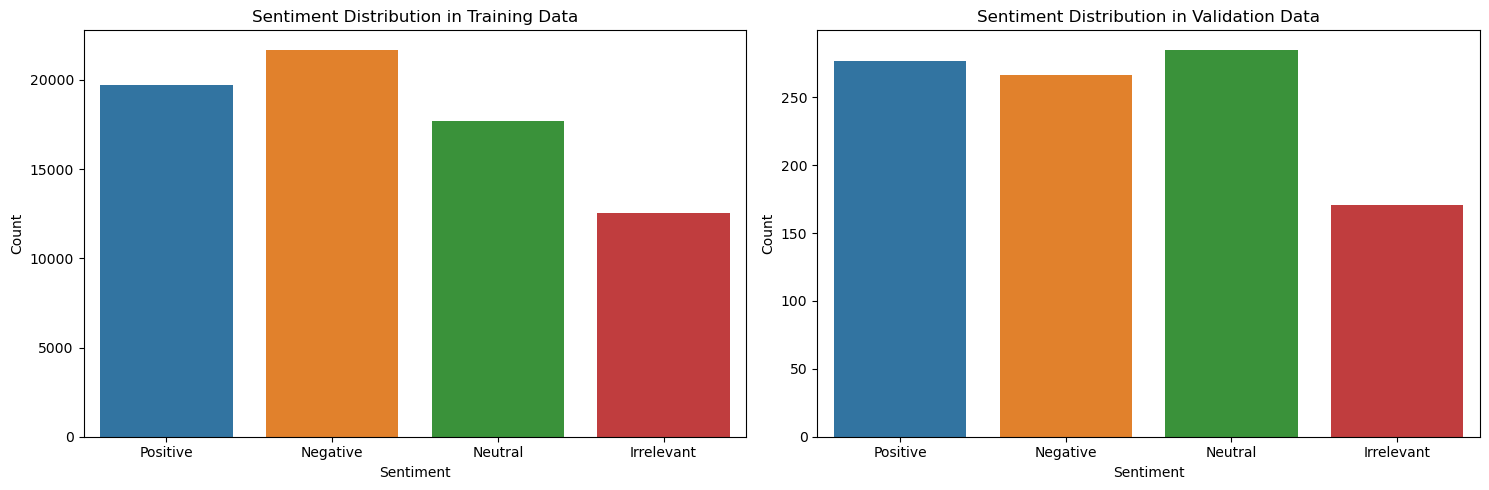

In [32]:
#Setting up the plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

#Plotting sentiment distribution for training data
sns.countplot(data=train_data_cleaned, x=train_data_cleaned.columns[2], order=['Positive', 'Negative', 'Neutral', 'Irrelevant'], ax=ax[0])
ax[0].set_title('Sentiment Distribution in Training Data')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Sentiment')

#Plotting sentiment distribution for validation data
sns.countplot(data=validation_data, x=validation_data.columns[2], order=['Positive', 'Negative', 'Neutral', 'Irrelevant'], ax=ax[1])
ax[1].set_title('Sentiment Distribution in Validation Data')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Sentiment')

plt.tight_layout()
plt.show()

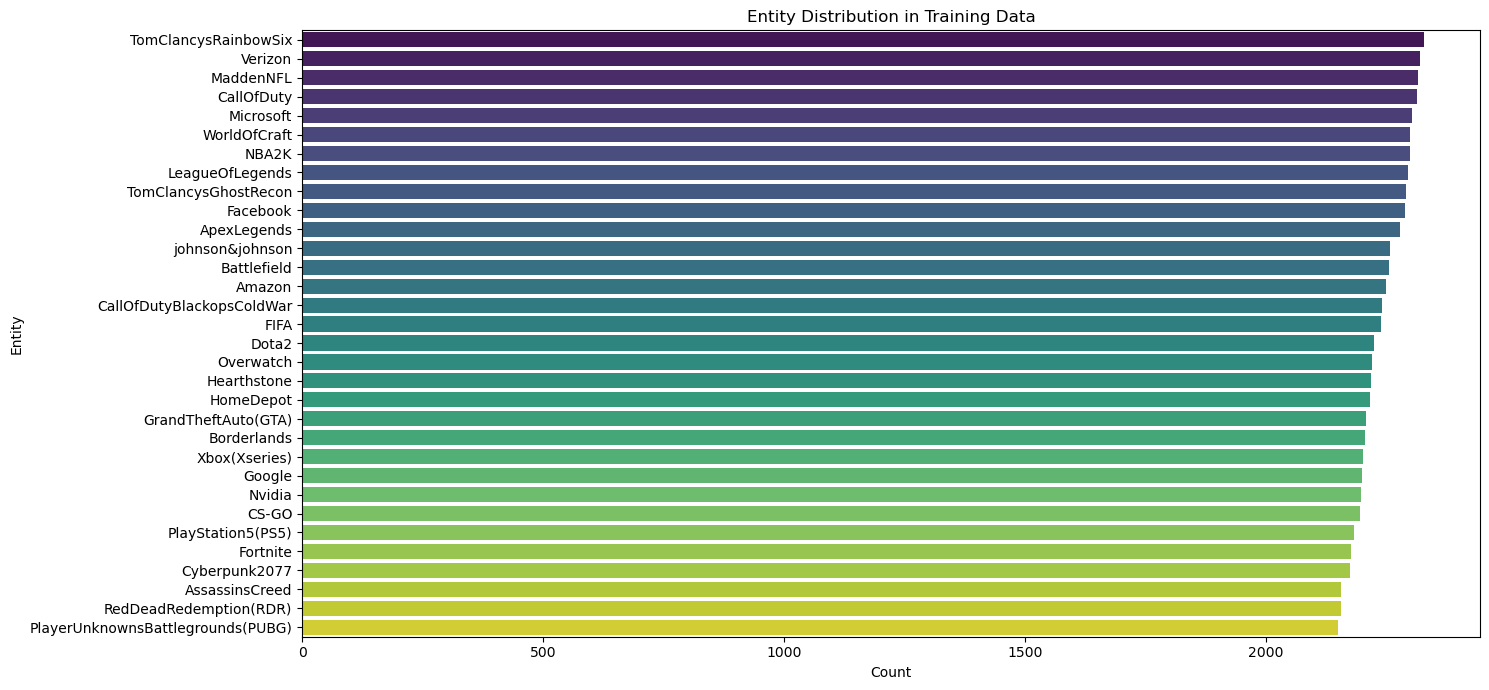

In [33]:
#Setting up the plot
plt.figure(figsize=(15, 7))

#Plotting entity distribution for training data
sns.countplot(data=train_data_cleaned, y=train_data_cleaned.columns[1], order=train_data_cleaned[train_data_cleaned.columns[1]].value_counts().index, palette='viridis')
plt.title('Entity Distribution in Training Data')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.tight_layout()
plt.show()

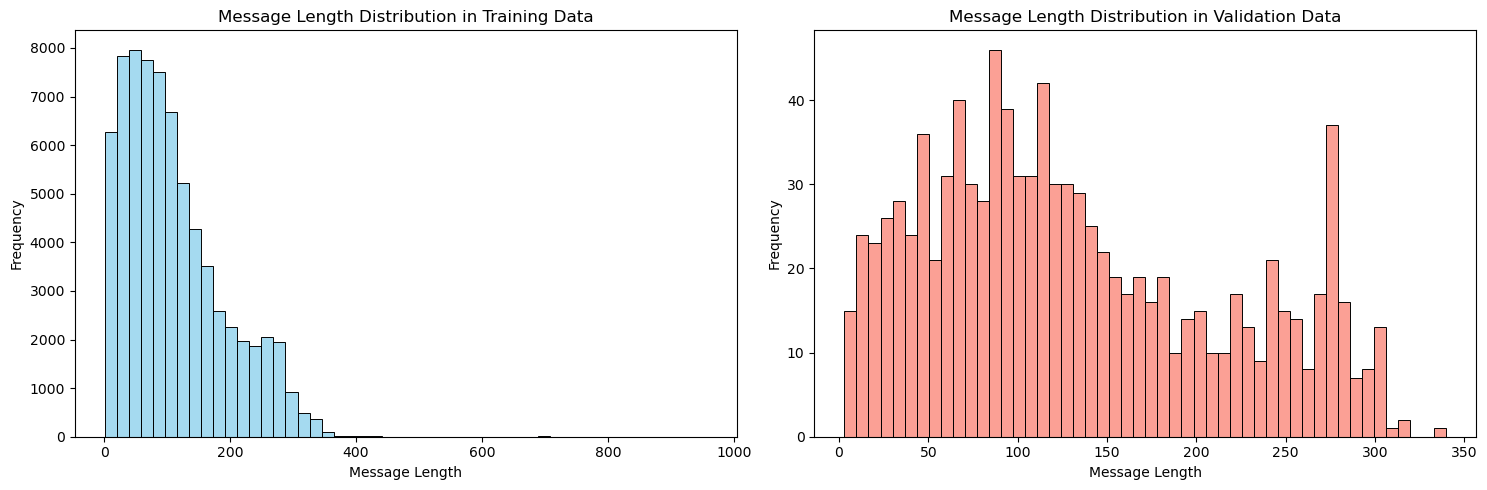

In [34]:
#Calculating the length of each message
train_data_cleaned['message_length'] = train_data_cleaned[train_data_cleaned.columns[3]].apply(len)
validation_data['message_length'] = validation_data[validation_data.columns[3]].apply(len)

#Setting up the plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

#Plotting message length distribution for training data
sns.histplot(train_data_cleaned['message_length'], bins=50, ax=ax[0], color='skyblue')
ax[0].set_title('Message Length Distribution in Training Data')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Message Length')

#Plotting message length distribution for validation data
sns.histplot(validation_data['message_length'], bins=50, ax=ax[1], color='salmon')
ax[1].set_title('Message Length Distribution in Validation Data')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Message Length')

plt.tight_layout()
plt.show()

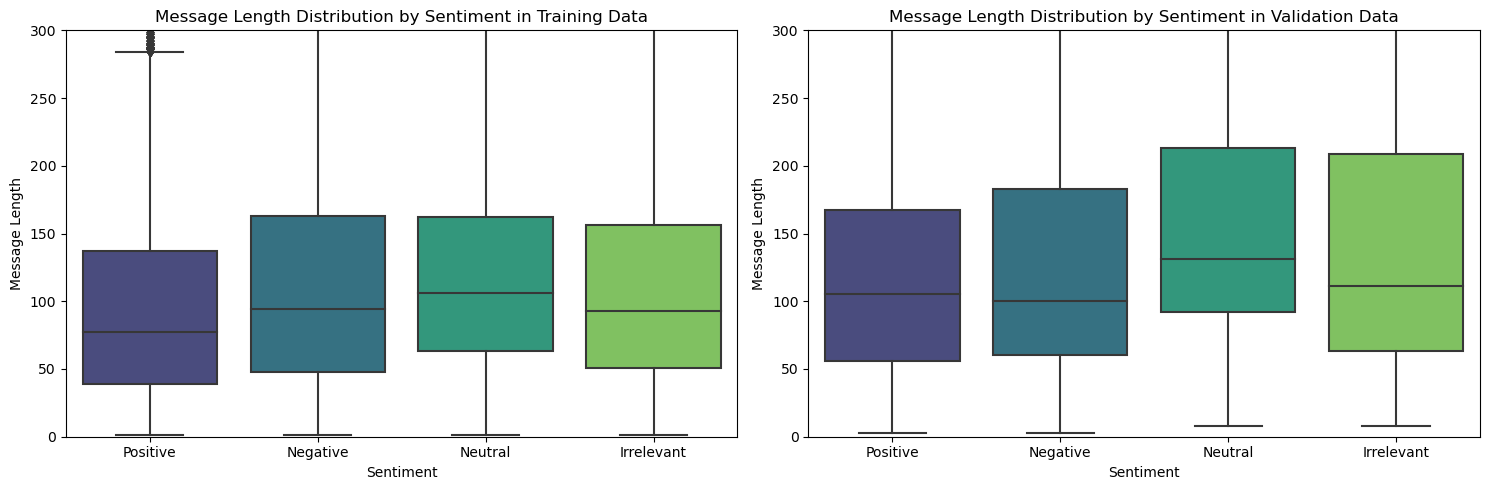

In [35]:
#Setting up the plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

#Plotting message length distribution by sentiment for training data
sns.boxplot(data=train_data_cleaned, x=train_data_cleaned.columns[2], y='message_length', ax=ax[0], palette='viridis', order=['Positive', 'Negative', 'Neutral', 'Irrelevant'])
ax[0].set_title('Message Length Distribution by Sentiment in Training Data')
ax[0].set_ylabel('Message Length')
ax[0].set_xlabel('Sentiment')
ax[0].set_ylim(0, 300)  # limiting y-axis for better visualization

#Plotting message length distribution by sentiment for validation data
sns.boxplot(data=validation_data, x=validation_data.columns[2], y='message_length', ax=ax[1], palette='viridis', order=['Positive', 'Negative', 'Neutral', 'Irrelevant'])
ax[1].set_title('Message Length Distribution by Sentiment in Validation Data')
ax[1].set_ylabel('Message Length')
ax[1].set_xlabel('Sentiment')
ax[1].set_ylim(0, 300)  # limiting y-axis for better visualization

plt.tight_layout()
plt.show()

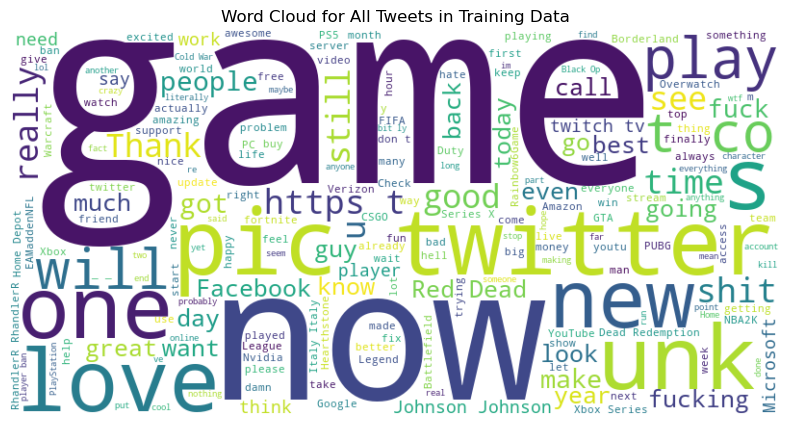

In [36]:
#Generating the word cloud for the entire training dataset
all_text = " ".join(tweet for tweet in train_data_cleaned[train_data_cleaned.columns[3]])
wordcloud_all = WordCloud(background_color='white', width=800, height=400).generate(all_text)
#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Tweets in Training Data')
plt.show()

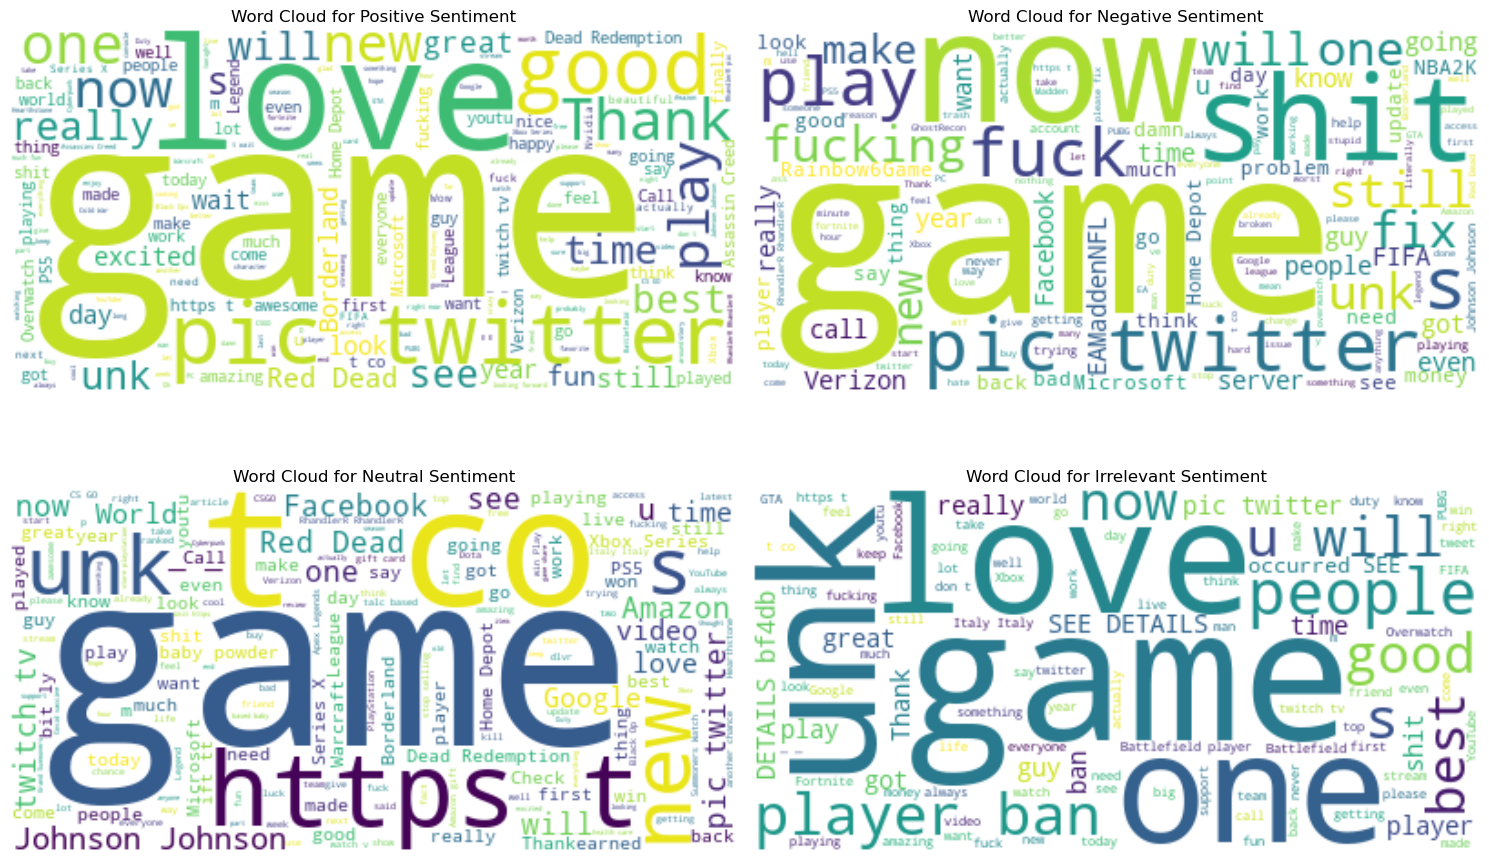

In [37]:
#Initializing sentiment categories
sentiments = ['Positive', 'Negative', 'Neutral', 'Irrelevant']

#Setting up the plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

#Generating and plotting word clouds for each sentiment
for sentiment, ax in zip(sentiments, axs.ravel()):
    sentiment_text = " ".join(tweet for tweet in train_data_cleaned[train_data_cleaned[train_data_cleaned.columns[2]] == sentiment][train_data_cleaned.columns[3]])
    wordcloud_sentiment = WordCloud(background_color='white', width=400, height=200).generate(sentiment_text)
    
    ax.imshow(wordcloud_sentiment, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for {sentiment} Sentiment')

plt.tight_layout()
plt.show()

In [38]:
#Alternative function to preprocess text without lemmatization or NLTK stopwords
def preprocess_text_simplified(text):
    #Converting to lowercase
    text = text.lower()
    #Simple tokenization using split (without relying on NLTK)
    tokens = text.split()
    #Removing special characters and numbers
    tokens = [token for token in tokens if token.isalpha()]
    return " ".join(tokens)

#Applying simplified preprocessing to training data
train_data_cleaned['processed_message_simplified'] = train_data_cleaned[train_data_cleaned.columns[3]].apply(preprocess_text_simplified)

#Extracting most frequent terms using CountVectorizer with simplified preprocessing
vectorizer_simplified = CountVectorizer(max_features=20)
X_simplified = vectorizer_simplified.fit_transform(train_data_cleaned['processed_message_simplified'])
frequent_terms_simplified = vectorizer_simplified.get_feature_names_out()

frequent_terms_simplified

array(['and', 'but', 'for', 'game', 'have', 'in', 'is', 'it', 'just',
       'my', 'not', 'of', 'on', 'so', 'that', 'the', 'this', 'to', 'with',
       'you'], dtype=object)

In [39]:
#Adjusting the labels: Convert "Irrelevant" labels to "Neutral"
train_data_cleaned[train_data_cleaned.columns[2]] = train_data_cleaned[train_data_cleaned.columns[2]].replace('Irrelevant', 'Neutral')
validation_data[validation_data.columns[2]] = validation_data[validation_data.columns[2]].replace('Irrelevant', 'Neutral')

In [40]:
updated_train_sentiment_distribution = train_data_cleaned[train_data_cleaned.columns[2]].value_counts()
updated_train_sentiment_distribution

Neutral     30245
Negative    21698
Positive    19712
Name: sentiment, dtype: int64

In [41]:
updated_validation_sentiment_distribution = validation_data[validation_data.columns[2]].value_counts()
updated_validation_sentiment_distribution

Neutral     456
Positive    277
Negative    266
Name: Irrelevant, dtype: int64

In [42]:
#Initializing the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features for computational efficiency

#Fitting and transforming the preprocessed text from the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data_cleaned['processed_message_simplified'])

#Applying simplified preprocessing to the validation data
validation_data['processed_message_simplified'] = validation_data[validation_data.columns[3]].apply(preprocess_text_simplified)

#Transforming the preprocessed text from the validation data
X_validation_tfidf = tfidf_vectorizer.transform(validation_data['processed_message_simplified'])

#Extracting target labels for training and validation
y_train = train_data_cleaned[train_data_cleaned.columns[2]]
y_validation = validation_data[validation_data.columns[2]]

X_train_tfidf.shape, X_validation_tfidf.shape

((71655, 5000), (999, 5000))

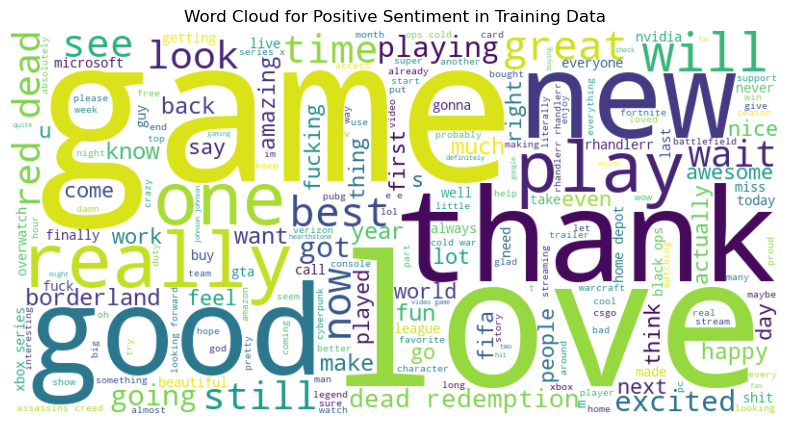

In [43]:
#Extracting text for Positive sentiment from the training dataset
positive_text = " ".join(tweet for tweet in train_data_cleaned[train_data_cleaned[train_data_cleaned.columns[2]] == 'Positive']['processed_message_simplified'])

#Generating word cloud for Positive sentiment
wordcloud_positive = WordCloud(background_color='white', width=800, height=400).generate(positive_text)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment in Training Data')
plt.show()

In [44]:
#The target variable for training and validation again
y_train = train_data_cleaned[train_data_cleaned.columns[2]]
y_validation = validation_data[validation_data.columns[2]]

#Creating the ML pipeline with TF-IDF vectorization and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(solver='sag', multi_class='auto', max_iter=10000))  # using 'sag' solver for faster convergence
])

#Training the pipeline model using the training data
pipeline.fit(train_data_cleaned['processed_message_simplified'], y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(max_iter=10000, solver='sag'))])

In [45]:
#Validating the model's performance on the validation dataset
validation_accuracy = pipeline.score(validation_data['processed_message_simplified'], y_validation)
validation_accuracy

0.8048048048048048

In [46]:
#Validating the model's performance on the training dataset
training_accuracy = pipeline.score(train_data_cleaned['processed_message_simplified'], y_train)
training_accuracy

0.7466331728420905

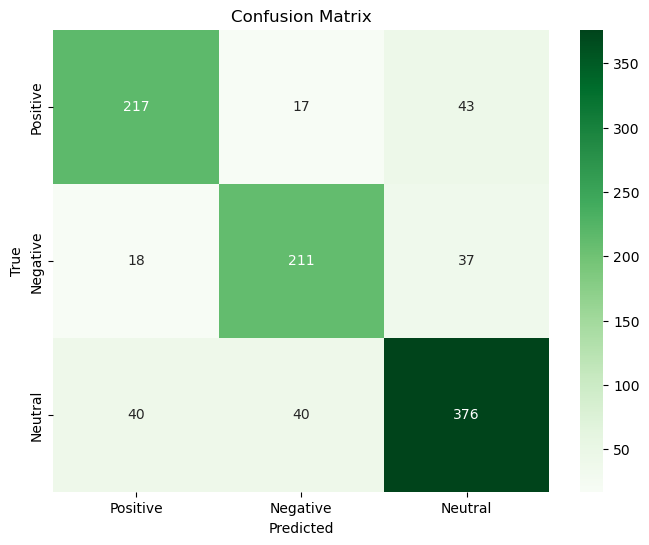

In [47]:
#Generating predictions on the validation data
y_validation_pred = pipeline.predict(validation_data['processed_message_simplified'])

#Creating a confusion matrix
conf_matrix = confusion_matrix(y_validation, y_validation_pred, labels=['Positive', 'Negative', 'Neutral'])

#Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

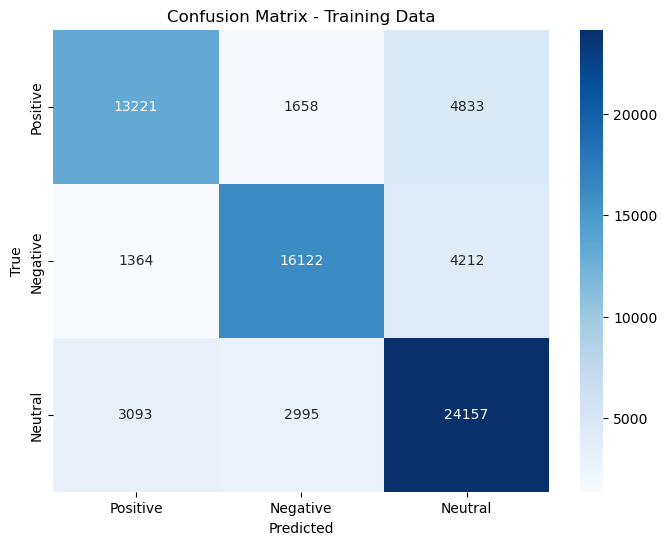

In [48]:
#Generating predictions on the training data
y_train_pred = pipeline.predict(train_data_cleaned['processed_message_simplified'])

#Creating a confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_train_pred, labels=['Positive', 'Negative', 'Neutral'])

#Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()